In this cycle we:



# 1 IMPORTS

In [1]:
import re
import inflection
import numpy                                          as np
import pandas                                         as pd
import sweetviz                                       as sv
import seaborn                                        as sns
import umap.umap_                                     as umap
import matplotlib.cm                                  as cm
import matplotlib.pyplot                              as plt
            
from plotly              import express               as px
from sklearn             import cluster               as c
from sklearn             import metrics               as m
from sklearn             import mixture               as mx
from IPython.display     import Image      
from sklearn             import ensemble              as en
from sklearn             import manifold              as mn
from sklearn             import decomposition         as dd
from sklearn             import preprocessing         as pp
from scipy.cluster       import hierarchy             as hc
from pandas_profiling    import ProfileReport
from sklearn.neighbors   import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer 
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

## 1.1 Definitions 

In [2]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## 1.2 Loading Data

In [3]:
df_raw = pd.read_csv('../data/ecommerce.csv', parse_dates=['InvoiceDate'])
# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

### 2.3.1 Treating Missing Values

In [4]:
# adding 'No description' to missing discription
df_raw['description'].fillna(value='NO DESCRIPTION', inplace=True)

# deleting NAs customer_id (this removed about 25% of our database)
# df_raw.dropna(subset=['customer_id'], inplace=True)

# creating customers_id
df_missing = df_raw.loc[df_raw['customer_id'].isna(), :]
df_not_missing = df_raw.loc[~df_raw['customer_id'].isna(), :]

df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df_raw = pd.merge( df_raw, df_backup, on='invoice_no', how='left' )

# coalesce 
df_raw['customer_id'] = df_raw['customer_id_x'].combine_first( df_raw['customer_id_y'] )

# drop extra columns
df_raw = df_raw.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )



## 2.4 Changing types

In [5]:
df_raw['customer_id'] = df_raw['customer_id'].astype( int )

## 2.5 Discriptive Statistics

In [6]:
df_clean = df_raw.copy()

# 3 DATAFRAME FILTERING

## 3.1 Line Filtering

In [7]:
# filtering zero values in unit_price (WE WILL CONSIDER THESE ITEMS AS PROMO OR ERROR)
df_clean.query('unit_price >= 0.04 ', inplace=True)

# bad users (apresentam padroes de compra bastante desconexo, poluindo nosso modelo)
df_clean = df_clean[~df_clean['customer_id'].isin( [16446] )]

# Considering negative quantities as devolutions and positive quantities as real purchases
df_clean_returns = df_clean.query('quantity < 0')
df_clean = df_clean.query('quantity >=0')

# removing stock codes that does not represent puchases
df_clean = df_clean[~df_clean['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# removing innacurate country information 
df_clean = df_clean[~df_clean['country'].isin( ['European Community', 'Unspecified' ] ) ]

# 5 FEATURE ENGINEERING

In [8]:
# ====================
# CREATING RFM TABLE
# ====================

# initiating df_rfm table with customers IDs
df_rfm = df_clean.drop( ['invoice_no', 'stock_code', 'description', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

In [9]:
# monetary
df_clean['gross_revenue'] = df_clean['quantity'] * df_clean['unit_price']
df_monetary = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_rfm = pd.merge( df_rfm, df_monetary, on='customer_id', how='left' )


In [10]:
# recency - last purchase
df_recency = df_clean[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df_clean['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_rfm = pd.merge( df_rfm, df_recency, on='customer_id', how='left' )

In [11]:
# amount of purchases
df_freq = df_clean[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={'invoice_no': 'amount_invoices'})
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )

In [12]:
# amount of purchased items
df_prod = df_clean[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'amount_items'})
df_rfm = pd.merge( df_rfm, df_prod, on='customer_id', how='left' )


In [13]:
# amount of purchased products
# Numero de produtos
df_freq = (df_clean.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'amount_products'} ) )
df_rfm = pd.merge( df_rfm, df_freq, on='customer_id', how='left' )


In [14]:
# average ticket
df_avg_ticket = df_clean[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_rfm = pd.merge( df_rfm, df_avg_ticket, on='customer_id', how='left')

In [15]:
# number of returns
df_number_returns = df_clean_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'amount_returns'})
df_number_returns['amount_returns'] = df_number_returns['amount_returns'] * -1
df_rfm = pd.merge( df_rfm, df_number_returns, on='customer_id', how='left')
df_rfm.loc[df_rfm['amount_returns'].isna(), 'amount_returns'] = 0
# df_rfm['amount_returns'].fillna(value=0, inplace=True)

In [16]:
# # Average recency days
# df_aux = df_clean[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
# df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
# df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date
# df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )
# df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# df_rfm = pd.merge( df_rfm, df_avg_recency_days, on='customer_id', how='left' )


In [17]:
# frequency purchase 
df_aux = ( df_clean[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

In [18]:
# basket size (Units by basket)
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )

In [19]:
df_aux = ( df_clean.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_rfm = pd.merge( df_rfm, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )

# 6 STATISTICAL ANALYSIS

In [20]:
df_rfm.dropna(inplace=True)

# 7 FEATURE SELECTION

In [21]:
df_rfm_raw = df_rfm.copy()
selected_cols = ['customer_id', 'gross_revenue', 'recency_days', 'amount_products', 'frequency', 'amount_returns']
df_rfm = df_rfm[selected_cols].copy()

# 8 DATA PREPARATION

## 8.1 Normalization

In [22]:
## Standard Scalaer
mm = pp.MinMaxScaler()


df_rfm['gross_revenue'] = mm.fit_transform( df_rfm[['gross_revenue']] )
df_rfm['recency_days']           = mm.fit_transform( df_rfm[['recency_days']] )
df_rfm['amount_products']          = mm.fit_transform( df_rfm[['amount_products']])
df_rfm['frequency']              = mm.fit_transform( df_rfm[['frequency']])
df_rfm['amount_returns']           = mm.fit_transform( df_rfm[['amount_returns']])

In [241]:
X = df_rfm.drop(columns=['customer_id']).copy()
X.head()

,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0.019312,0.997319,0.037770,1.000000,0.000539
1,0.011579,0.150134,0.021692,0.001345,0.000485
2,0.024020,0.005362,0.029476,0.002052,0.000687
3,0.003396,0.254692,0.003445,0.000734,0.000000
4,0.003137,0.892761,0.000255,0.003985,0.000296


## 8.2 Space Study

### 8.2.1 PCA

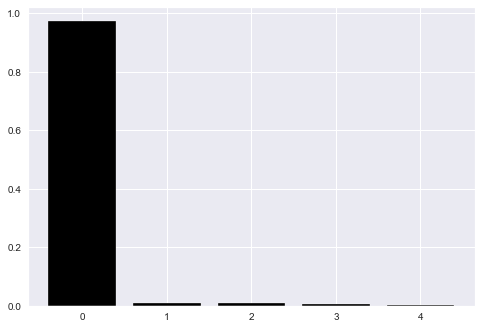

In [148]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

### 8.2.2 UMAP

In [242]:
reducer = umap.UMAP( n_components=4, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]
df_umap['embedding_z'] = embedding[:, 2]
df_umap['embedding_w'] = embedding[:, 3]
# df_umap['embedding_u'] = embedding[:, 4]

# # plot UMAP
# sns.scatterplot( x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_umap )

### 8.2.3 t-SNE

In [226]:
reducer = mn.TSNE( n_components=3, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]
df_tsne['embedding_z'] = embedding[:, 2]

# # plot UMAP
# sns.scatterplot( x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tsne )

ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

### 8.2.4 TREE Based Embedding

In [191]:
# training dataset
X = df_rfm.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df_rfm['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf 

# dataframe Leaf

df_leaf = pd.DataFrame( rf_model.apply( X ) )

# Reduzer dimensionality
reducer = umap.UMAP(n_components=5, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
df_tree['embedding_z'] = embedding[:, 2]
df_tree['embedding_w'] = embedding[:, 3]
df_tree['embedding_u'] = embedding[:, 4]

# # plot UMAP
# sns.scatterplot( x='embedding_x', 
#                  y='embedding_y', 
#                  data=df_tree )

In [28]:
# # Saving the embedded space
# df_tree.to_csv('../data/embedded_space.csv', index=False)

# 9 HYPERPARAMETER FINE TUNNING

In [243]:
# clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange(2,31,1)
# X = df_rfm.drop( columns=['customer_id'] ) # no espaco original dos dados
# X = df_tree.copy() # no espaco transformado
# X = df_pca.copy() # no espaco transformado
X = df_umap.copy() # no espaco transformado
# X = df_tsne.copy() # no espaco transformado

# 10 CHOSEN MODEL

In [244]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [245]:
df_eda = X.copy()
df_eda['cluster'] = labels
df_rfm_raw['cluster'] = labels

In [246]:
## WSS ( Within-cluster sum of square)
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 97056.1171875
SS value: 0.5443276166915894


# 11 BUSINESS PERFORMANCE

In [233]:
df_cluster_embed = X.copy()
df_cluster_embed['cluster'] = labels
df_cluster_embed.head()

,embedding_x,embedding_y,embedding_z,embedding_w,cluster
0,-3.029993,9.952247,8.345515,1.701905,4
1,13.304445,13.189207,8.327514,8.831138,6
2,11.384762,9.170521,15.499040,-3.444309,3
3,10.469833,7.522410,7.934718,10.154498,6
4,8.770447,-0.304306,8.852541,13.856702,6


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

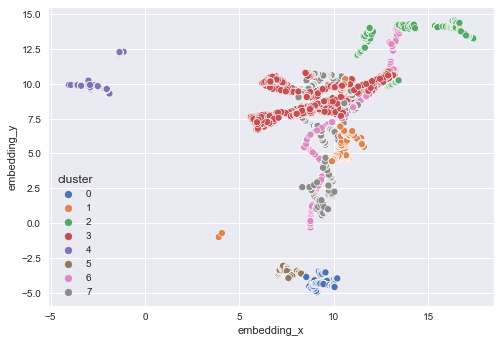

In [234]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df_cluster_embed, palette='deep')

In [235]:
# Number of customer
df_cluster = df_rfm_raw[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_rfm_raw[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_rfm_raw[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg products_no
df_invoice_no = df_rfm_raw[['amount_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Frequency
df_invoice_no = df_rfm_raw[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Returns
df_invoice_no = df_rfm_raw[['amount_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0,436,7.655838,526.068372,258.018349,43.208716,1.018349,1.360092
1,1,508,8.920105,614.771890,71.114173,46.501969,1.058024,6.198819
2,2,452,7.936787,970.335310,20.681416,80.353982,0.998709,1.283186
3,3,1838,32.273924,3717.091970,18.852013,163.760609,0.039972,42.933079
4,4,277,4.863916,906.624801,362.581227,65.126354,1.051473,2.490975
5,5,356,6.251097,857.132837,311.974719,63.997191,1.005618,210.376404
6,6,916,16.084284,1231.994727,129.581878,62.990175,0.034100,22.239083
7,7,912,16.014047,666.228388,156.894737,53.854167,1.019737,3.419956


In [236]:
df_cluster.style.highlight_max(subset=['gross_revenue', 'amount_products', 'frequency'], color='lightgreen', axis=0 )\
.highlight_min(subset=['recency_days', 'amount_returns'], color='lightgreen', axis=0 )\
.highlight_max(subset=['recency_days', 'amount_returns'], color='pink', axis=0 )\
.highlight_min(subset=['gross_revenue', 'amount_products', 'frequency'], color='pink', axis=0 )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,amount_products,frequency,amount_returns
0,0,436,7.655838,526.068372,258.018349,43.208716,1.018349,1.360092
1,1,508,8.920105,614.771890,71.114173,46.501969,1.058024,6.198819
2,2,452,7.936787,970.335310,20.681416,80.353982,0.998709,1.283186
3,3,1838,32.273924,3717.091970,18.852013,163.760609,0.039972,42.933079
4,4,277,4.863916,906.624801,362.581227,65.126354,1.051473,2.490975
5,5,356,6.251097,857.132837,311.974719,63.997191,1.005618,210.376404
6,6,916,16.084284,1231.994727,129.581878,62.990175,0.034100,22.239083
7,7,912,16.014047,666.228388,156.894737,53.854167,1.019737,3.419956


Cluster A: 
- Number of customers: 466 (16.8% of customers )
- Average Recency: 21.5 days
- Average invoice_no: 425 
- Average Gross Revenue: U\$8,855.52
- Average purchases/day: 0.09
- Average products return: 150.6

Cluster B:
- Number of customers: 356 (12.8% of customers )
- Average Recency: 50 days
- Average invoice_no: 99.9
- Average Gross Revenue: U\$3,002.54
- Average purchases/day: 0.04
- Average products return: 19.7

Cluster C:
- Number of customers: 568 (20.50% of customers )
- Average Recency: 41.9 days
- Average invoice_no: 135.40 
- Average Gross Revenue: U\$2,430.80
- Average purchases/day: 0.04
- Average products return: 20.5

Cluster D:
- Number of customers: 469 (16.9% of customers )
- Average Recency: 59.27 days
- Average invoice_no: 57.6 
- Average Gross Revenue: U\$1,269.62
- Average purchases/day: 0.03
- Average products return: 9

Cluster E:
- Number of customers: 316 (11.39% of customers )
- Average Recency: 73.3 days
- Average invoice_no: 37.2 
- Average Gross Revenue: U\$988.2
- Average purchases/day: 0.03
- Average products return: 10.95

Cluster F:
- Number of customers: 147 (5.3% of customers )
- Average Recency: 78.5 days
- Average invoice_no: 27.9 
- Average Gross Revenue: U\$854.67
- Average purchases/day: 0.03
- Average products return: 3.17

Cluster G:
- Number of customers: 299 (10.78% of customers )
- Average Recency: 46.4 days
- Average invoice_no: 14.43 
- Average Gross Revenue: U\$645.28
- Average purchases/day: 0.04
- Average products return: 0.96

Cluster H:
- Number of customers: 152 (15.48% of customers )
- Average Recency: 191 days
- Average invoice_no: 14.1 
- Average Gross Revenue: U\$570.64
- Average purchases/day: 0.09
- Average products return: 15.8